In [1]:
%load_ext autoreload
%autoreload 2
%load_ext functionizer

In [2]:
def save_fig(fig, name):
    fig.savefig(rf"C:\Users\wuyua\OneDrive - The University of Western Ontario\Research\crm\paper\figure\{name}.png", bbox_inches="tight")

In [3]:
from solvers import hr_grid_forward_step_size_independent_1d, uw_grid_forward_step_size_independent_1d, pa_forward_step, hr_grid_forward_step_size_dependent_1d, uw_grid_forward_step_size_dependent_1d
import numpy as np
from matplotlib import pyplot as plt
from time import perf_counter
from scipy.stats import norm
from scipy.integrate import trapz
from tqdm.notebook import tqdm
from scipy.stats import binned_statistic
import pandas as pd
from compress import compress

# 1D batch size dependent

In [379]:
def solubility(T):
    return 1.721e-4 * T ** 2 - 5.88e-3 * T + 0.1286

def T_profile(t):
    return 32-4*(1-np.exp(-t/18600))

def birth_rate(T, c, v):
    kb = 4.64e-7
    b = 1.78
    sol = solubility(T)
    if c > sol:
        B = kb * v * ((c - sol) / sol) ** b
    else:
        B = 0.
    return B

def growth_rate(T, c, L):
    kg = 1.16e2
    g = 1.32
    sol = solubility(T)
    G = kg * ((c - sol) / sol) ** g * (1 + 0.1*L)
    return G
    
density = 2.11e-12 # g/um3

dL = 0.5
L_edges = np.arange(0, 1100, dL)
L_centers = 0.5 * (L_edges[1:] + L_edges[:-1])
n_init = np.zeros_like(L_centers)
non_zero_idx = (L_centers >= 180.5) & (L_centers <= 210.5)
L_non_zero = L_centers[non_zero_idx]
n_init[non_zero_idx] = -3.48e-4 * L_non_zero ** 2 + 0.136 * L_non_zero - 13.21
T_init = T_profile(0)
c_init = solubility(T_init)
v_init = trapz(n_init * L_centers ** 3, L_centers)


In [380]:
t_total = 1000

dt_max = 1



# HR
n_hr = n_init.copy()
t = 0
pbar = tqdm(total=t_total, desc="HR")
c = c_init
v = v_init
cs_hr = [c]
ts_hr =[t]
vs_hr = [v]
cnt_hr = [trapz(n_init, L_centers)]

while t < t_total:
    
    T = T_profile(t)
    
    G = growth_rate(T, c, L_centers)
    B = birth_rate(T, c, v)
    
    # compute time step
    dt = dL / np.max(G)
    dt = np.min([dt, t_total-t, dt_max])
    
    # Update nucleation
    n_hr[0] += B * dt / dL
    
    # Update growth
    n_hr = hr_grid_forward_step_size_dependent_1d(n_hr, dL, dt, G)
    
    # Update concentration
    v_new = trapz(n_hr * L_centers ** 3, L_centers)
    c -= (v_new - v) * density
    v = v_new
    
    t += dt
    pbar.update(dt)
    
    ts_hr.append(t)
    cs_hr.append(c)
    vs_hr.append(v)
    cnt_hr.append(trapz(n_hr, L_centers))
pbar.close()

# UW
n_uw = n_init.copy()
t = 0
pbar = tqdm(total=t_total, desc="UW")
c = c_init
v = v_init
cs_uw = [c]
ts_uw =[t]
vs_uw = [v]
cnt_uw = [trapz(n_init, L_centers)]
while t < t_total:
    T = T_profile(t)
    
    G = growth_rate(T, c, L_centers)
    B = birth_rate(T, c, v)
    
    # compute time step
    dt = dL / np.max(G)
    dt = np.min([dt, t_total-t, dt_max])
    
    # Update nucleation
    n_uw[0] += B * dt / dL
    
    # Update growth
    n_uw = uw_grid_forward_step_size_dependent_1d(n_uw, dL, dt, G)
    
    # Update concentration
    v_new = trapz(n_uw * L_centers ** 3, L_centers)
    c -= (v_new - v) * density
    v = v_new
    
    t += dt
    pbar.update(dt)
    
    ts_uw.append(t)
    cs_uw.append(c)
    vs_uw.append(v)
    cnt_uw.append(trapz(n_uw, L_centers))
pbar.close()
    


HR:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-380-f0a7cf35d7ec>:26: RuntimeWarning: divide by zero encountered in double_scalars
  dt = dL / np.max(G)


UW:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-380-f0a7cf35d7ec>:66: RuntimeWarning: divide by zero encountered in double_scalars
  dt = dL / np.max(G)


In [381]:

# PA
n_pa = n_init.copy()
N_pa = np.vstack([L_centers, n_pa * dL]).T
N_pa = N_pa[N_pa[:, -1] > 0]
t = 0
pbar = tqdm(total=t_total, desc="PA")
c = c_init
v = (N_pa[:, 0] ** 3 * N_pa[:, -1]).sum()
cs_pa = [c]
ts_pa =[t]
vs_pa = [v]
cnt_pa = [N_pa[:, -1].sum()]
while t < t_total:
    T = T_profile(t)
    
    G = growth_rate(T, c, N_pa[:, 0])
    B = birth_rate(T, c, v)
    
    # compute time step
    dt = dL / np.max(G)
    dt = np.min([dt, t_total-t, dt_max])
    
    # Update nucleation
    if B != 0:
        N_pa = np.vstack([N_pa, np.array([0, B * dt])])

        # recalculate due to the new row
        G = growth_rate(T, c, N_pa[:, 0])
    
    # Update growth
    # N_pa = pa_forward_step(N_pa, dt, np.expand_dims(G, 1))
    N_pa[:, 0] += G * dt
    # Update concentration
    v_new = (N_pa[:, 0] ** 3 * N_pa[:, -1]).sum()
    c -= (v_new - v) * density
    v = v_new
    
    t += dt
    pbar.update(dt)
    
    ts_pa.append(t)
    cs_pa.append(c)
    vs_pa.append(v)
    cnt_pa.append(N_pa[:, -1].sum())
pbar.close()

PA:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-381-74ce0cbba82e>:20: RuntimeWarning: divide by zero encountered in double_scalars
  dt = dL / np.max(G)


In [382]:
# PAC
n_pac = n_init.copy()
N_pac = np.vstack([L_centers, n_pac * dL]).T
N_pac = N_pac[N_pac[:, -1] > 0]
t = 0
pbar = tqdm(total=t_total, desc="PAC")
c = c_init
v = (N_pac[:, 0] ** 3 * N_pac[:, -1]).sum()
cs_pac = [c]
ts_pac =[t]
vs_pac = [v]
cnt_pac = [N_pac[:, -1].sum()]
while t < t_total:
    T = T_profile(t)
    
    G = growth_rate(T, c, N_pac[:, 0])
    B = birth_rate(T, c, v)
    
    # compute time step
    dt = dL / np.max(G)
    dt = np.min([dt, t_total-t, dt_max])
    
    # Update nucleation
    if B != 0:
        N_pac = np.vstack([N_pac, np.array([0, B * dt])])

        # recalculate due to the new row
        G = growth_rate(T, c, N_pac[:, 0])

    # recalculate due to the new row
    G = growth_rate(T, c, N_pac[:, 0])
    
    # Update growth
    # N_pa = pa_forward_step(N_pa, dt, np.expand_dims(G, 1))
    N_pac[:, 0] += G * dt
    # Update concentration
    v_new = (N_pac[:, 0] ** 3 * N_pac[:, -1]).sum()
    c -= (v_new - v) * density
    v = v_new
    N_pac = compress(N_pac, 0.5, np.array([3.0]), 1.0)

    t += dt
    pbar.update(dt)
    
    ts_pac.append(t)
    cs_pac.append(c)
    vs_pac.append(v)
    
    cnt_pac.append(N_pac[:, -1].sum())

pbar.close()

PAC:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-382-163cefaec436>:20: RuntimeWarning: divide by zero encountered in double_scalars
  dt = dL / np.max(G)


In [383]:
from KDEpy import FFTKDE
def get_kde_xy(N, num=2000):
    kde = FFTKDE(bw=0.9, kernel="epa")
    low_bound = 0
    data = N[:, 0]
    data = np.concatenate((data, 2 * low_bound - data))
    weight = np.concatenate((N[:, 1], N[:, 1]))
    kde.fit(data, weight)
    x, y = kde.evaluate(num)
    y = y*2* N[:, -1].sum()
    idx = x > 0
    x = x[idx]
    y = y[idx]
    return x, y
pa_x, pa_y = get_kde_xy(N_pa)
pac_x, pac_y = get_kde_xy(N_pac)

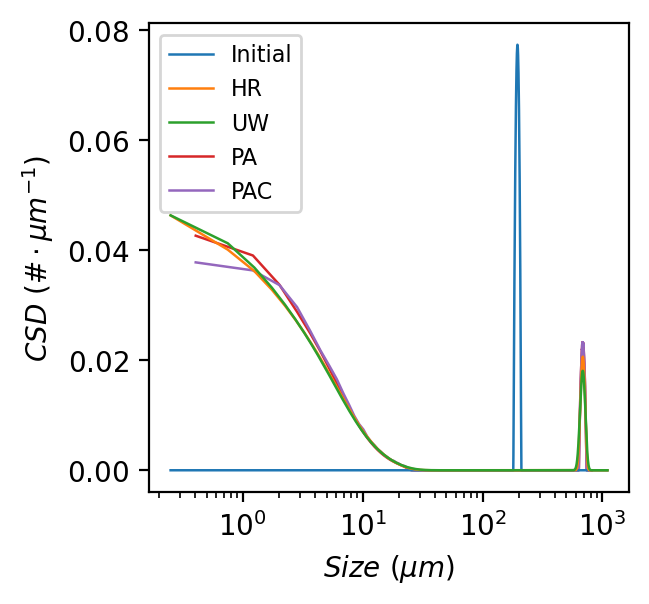

In [384]:
lw = 0.9
fig, ax = plt.subplots(figsize=(3.1, 3.1), dpi=200)
ax.plot(L_centers, n_init, label="Initial", lw=lw)
ax.plot(L_centers, n_hr, label="HR", lw=lw)
ax.plot(L_centers, n_uw, label="UW", lw=lw)

ax.plot(pa_x, pa_y, "-", label="PA", zorder=0, lw=lw)
ax.plot(pac_x, pac_y, "-", label="PAC", zorder=0, lw=lw)
ax.set_xlabel("$Size\ (\mu m)$")
ax.set_ylabel("$CSD\ (\#\cdot \mu m^{-1})$")
ax.ticklabel_format(axis='y', style='scientific', useMathText=True, useOffset=True, scilimits=(-3, 3))
ax.legend(fontsize=8)
ax.set_xscale("log")

In [385]:
save_fig(fig, "size_dependent_batch_csd")

(-0.001, 0.028)

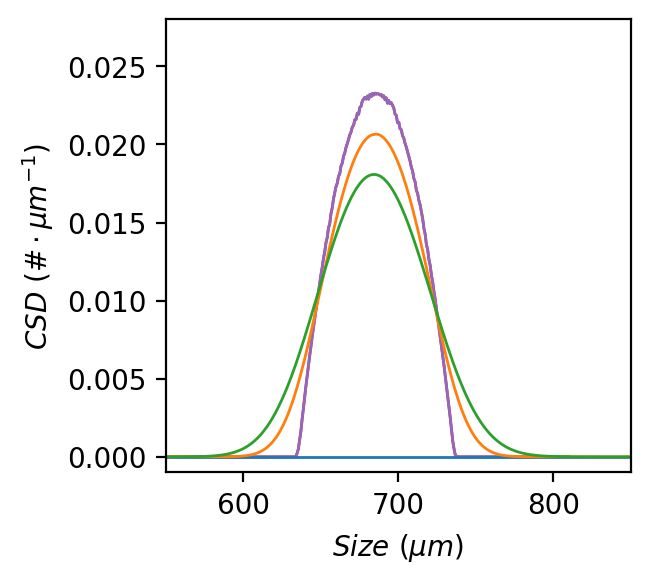

In [386]:
lw = 1.0
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
ax.plot(L_centers, n_init, label="Initial", lw=lw)
ax.plot(L_centers, n_hr, label="HR", lw=lw)
ax.plot(L_centers, n_uw, label="UW", lw=lw)

ax.plot(pa_x, pa_y, "-", label="PA", zorder=0, lw=lw)
ax.plot(pac_x, pac_y, "-", label="PAC", zorder=0, lw=lw)
ax.set_xlabel("$Size\ (\mu m)$")
ax.set_ylabel("$CSD\ (\#\cdot \mu m^{-1})$")

# ax.legend(fontsize=8)
ax.set_xlim([550, 850])
ax.set_ylim([-0.001,0.028])

In [387]:
save_fig(fig, "size_dependent_batch_partial_csd")

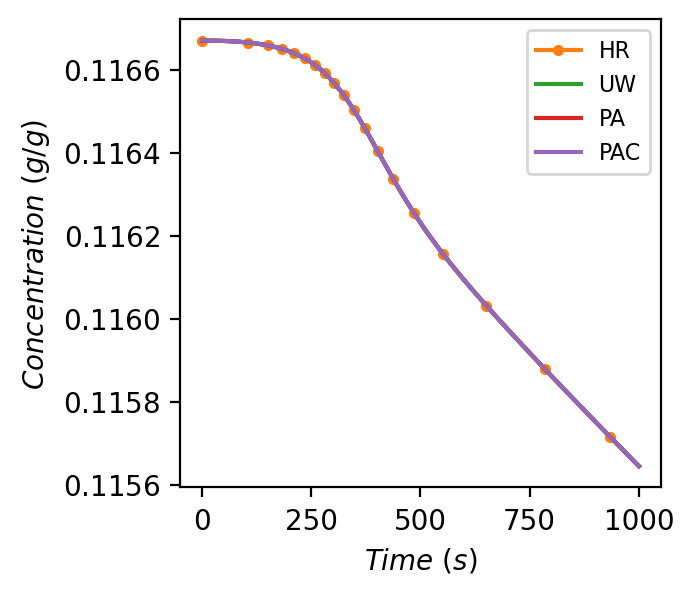

In [388]:
fig, ax = plt.subplots(figsize=(3.1, 3.1), dpi=200)
ax.plot(ts_hr, cs_hr, 'C1.-',label="HR",markevery=150)
ax.plot(ts_uw, cs_uw, 'C2',label="UW")
ax.plot(ts_pa, cs_pa, 'C3',label="PA")
ax.plot(ts_pac, cs_pac, 'C4',label="PAC")
ax.set_xlabel("$Time\ (s)$")
ax.set_ylabel("$Concentration\ (g/g)$")
ax.ticklabel_format(axis='y', style='scientific', useMathText=True, useOffset=True, scilimits=(-3, 3))
ax.legend(fontsize=8)

In [389]:
save_fig(fig, "size_dependent_batch_concentration_profile")

# Increase grid density and do HR again

In [390]:
def hr_hd_simulation():
    dL = 0.1
    L_edges = np.arange(0, 1100, dL)
    L_centers = 0.5 * (L_edges[1:] + L_edges[:-1])
    n_init = np.zeros_like(L_centers)
    non_zero_idx = (L_centers >= 180.5) & (L_centers <= 210.5)
    L_non_zero = L_centers[non_zero_idx]
    n_init[non_zero_idx] = -3.48e-4 * L_non_zero ** 2 + 0.136 * L_non_zero - 13.21
    T_init = T_profile(0)
    c_init = solubility(T_init)
    v_init = trapz(n_init * L_centers ** 3, L_centers)
    t_total = 1000

    dt_max = 1



    n_hr = n_init.copy()
    t = 0
    pbar = tqdm(total=t_total, desc="HR")
    c = c_init
    v = v_init
    cs_hr = [c]
    ts_hr =[t]
    vs_hr = [v]
    cnt_hr = [trapz(n_init, L_centers)]

    while t < t_total:

        T = T_profile(t)

        G = growth_rate(T, c, L_centers)
        B = birth_rate(T, c, v)

        # compute time step
        dt = dL / np.max(G)
        dt = np.min([dt, t_total-t, dt_max])

        # Update nucleation
        n_hr[0] += B * dt / dL

        # Update growth
        n_hr = hr_grid_forward_step_size_dependent_1d(n_hr, dL, dt, G)

        # Update concentration
        v_new = trapz(n_hr * L_centers ** 3, L_centers)
        c -= (v_new - v) * density
        v = v_new

        t += dt
        pbar.update(dt)

        ts_hr.append(t)
        cs_hr.append(c)
        vs_hr.append(v)
        cnt_hr.append(trapz(n_hr, L_centers))
    pbar.close()
    return ts_hr, cs_hr, vs_hr, cnt_hr
ts_hr_hd, cs_hr_hd, vs_hr_hd, cnt_hr_hd = hr_hd_simulation()

HR:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-390-6b816def00cb>:36: RuntimeWarning: divide by zero encountered in double_scalars
  dt = dL / np.max(G)


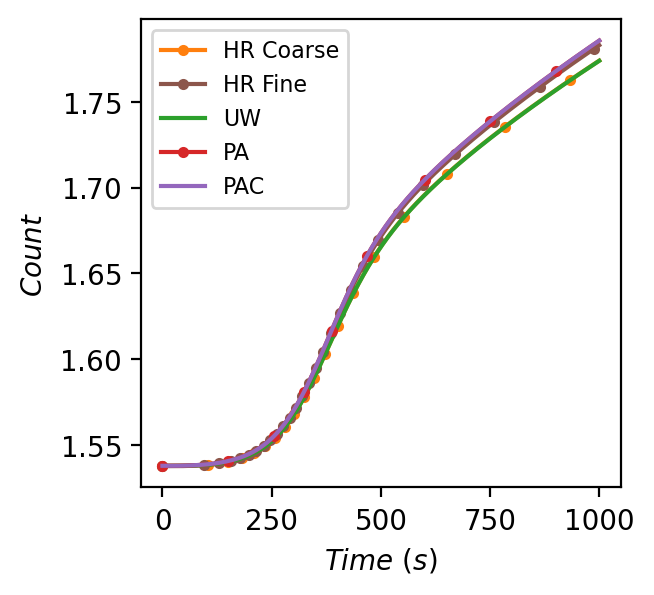

In [391]:
fig, ax = plt.subplots(figsize=(3.1, 3.1), dpi=200)
ax.plot(ts_hr, cnt_hr, 'C1.-',label="HR Coarse",markevery=150)
ax.plot(ts_hr_hd, cnt_hr_hd, 'C5.-',label="HR Fine",markevery=500)

ax.plot(ts_uw, cnt_uw, 'C2',label="UW")
ax.plot(ts_pa, cnt_pa, 'C3.-',label="PA",markevery=150)
ax.plot(ts_pac, cnt_pac, 'C4',label="PAC")
ax.set_xlabel("$Time\ (s)$")
ax.set_ylabel("$Count$")
ax.ticklabel_format(axis='y', style='scientific', useMathText=True, useOffset=True, scilimits=(-3, 3))
ax.legend(fontsize=8)

In [392]:
save_fig(fig, "size_dependent_batch_count_profile")

# Continuous Crystallization

In [397]:
def solubility(T):
    return 1.721e-4 * T ** 2 - 5.88e-3 * T + 0.1286

def T_profile(t):
    return 32-4*(1-np.exp(-t/18600))

def birth_rate(T, c, v):
    kb = 4.64e-7
    b = 1.78
    sol = solubility(T)
    if c > sol:
        B = kb * ((c - sol) / sol) ** b
    else:
        B = 0.
    return B

def growth_rate(T, c, L, beta=0.):
    kg = 1.16e2
    g = 1.32
    sol = solubility(T)
    G = kg * ((c - sol) / sol) ** g * (1 + beta*L)
    return G


dL = 0.5
L_edges = np.arange(0, 1000, dL)
L_centers = 0.5 * (L_edges[1:] + L_edges[:-1])
n_init = np.zeros_like(L_centers)
non_zero_idx = (L_centers >= 180.5) & (L_centers <= 210.5)
L_non_zero = L_centers[non_zero_idx]
n_init[non_zero_idx] = -3.48e-4 * L_non_zero ** 2 + 0.136 * L_non_zero - 13.21
T_init = T_profile(0)
c_init = solubility(T_init)
v_init = trapz(n_init * L_centers ** 3, L_centers)

## Single stage example

In [458]:
growth_fcn = hr_grid_forward_step_size_dependent_1d
residence_time = 100
t_total = 1000
T = 31.5
time_step_scale = 0.5

dt_max = 1
beta = 0.01


In [459]:
%%functionalize single_stage_simulation -a growth_fcn beta -r ts cs vs cnts n --skip
n = n_init.copy()
# n = np.zeros_like(n_init)

c = c_init

v = trapz(n * L_centers**3, L_centers)

t = 0
pbar = tqdm(total=t_total, desc="single stage")

cs = [c]
ts =[t]
vs = [v]
cnts = [trapz(n, L_centers)]

while t < t_total:
    G = growth_rate(T, c, L_centers, beta)
    B = birth_rate(T, c, v)


    # compute time step
    dt = dL / np.max(G)
    dt = np.min([dt, dt_max]) * time_step_scale
    dt = np.min([dt, t_total-t])
    # Update nucleation
    n[0] += B * dt / dL

    # Update growth
    n = growth_fcn(n, dL, dt, G)

    # Update concentration
    v_new = trapz(n * L_centers ** 3, L_centers)
    c -= (v_new - v) * density
    v = v_new

    # Update continuous
    c_in = c_init
    n_in = 0

    c += (c_in - c) * dt / residence_time
    n += (n_in - n) * dt / residence_time

    t += dt
    pbar.update(dt)

    ts.append(t)
    cs.append(c)
    vs.append(v)
    cnts.append(trapz(n, L_centers))

pbar.close()

In [460]:
ts_hr_neg, cs_hr_neg, vs_hr_neg, cnts_hr_neg, n_hr_neg = single_stage_simulation(hr_grid_forward_step_size_dependent_1d, -0.0005)
ts_uw, cs_uw, vs_uw, cnts_uw, n_uw = single_stage_simulation(uw_grid_forward_step_size_dependent_1d, 0.005)
ts_hr, cs_hr, vs_hr, cnts_hr, n_hr = single_stage_simulation(hr_grid_forward_step_size_dependent_1d, 0.005)

ts_hr_ind, cs_hr_ind, vs_hr_ind, cnts_hr_ind, n_hr_ind = single_stage_simulation(hr_grid_forward_step_size_dependent_1d, 0.)


single stage:   0%|          | 0/1000 [00:00<?, ?it/s]

single stage:   0%|          | 0/1000 [00:00<?, ?it/s]

single stage:   0%|          | 0/1000 [00:00<?, ?it/s]

single stage:   0%|          | 0/1000 [00:00<?, ?it/s]

In [672]:
# PAC
beta = 0.00
n_pac = n_init.copy()
N_pac = np.vstack([L_centers, n_pac * dL]).T
N_pac = N_pac[N_pac[:, -1] > 0]
t = 0

pbar = tqdm(total=t_total, desc="PAC")
c = c_init
v = (N_pac[:, 0] ** 3 * N_pac[:, -1]).sum()
cs_pac = [c]
ts_pac =[t]
vs_pac = [v]
cnt_pac = [N_pac[:, -1].sum()]

while t < t_total:
    
    G = growth_rate(T, c, N_pac[:, 0], beta)
    B = birth_rate(T, c, v)
    
    # compute time step
    dt = dL / np.max(G) * time_step_scale*10
    dt = np.min([dt, dt_max])
    dt = np.min([dt, t_total-t])
#     dt =1##################
    
    # Update nucleation
    if B != 0:
        N_pac = np.vstack([N_pac, np.array([0, B * dt])])

        # recalculate due to the new row
        G = growth_rate(T, c, N_pac[:, 0], beta)
    
    # Update growth
    # N_pa = pa_forward_step(N_pa, dt, np.expand_dims(G, 1))
    N_pac[:, 0] += G * dt
    # Update concentration
    v_new = (N_pac[:, 0] ** 3 * N_pac[:, -1]).sum()
    c -= (v_new - v) * density
    v = v_new
    
    # Update continuous
    c_in = c_init

    c += (c_in - c) * dt / residence_time
    N_pac[:, -1] += -N_pac[:, -1] * dt / residence_time
    
    if N_pac.shape[0] > 1000:
        N_pac = compress(N_pac, 1.0, np.array([3.0]), 1.0)
        
#     N_pac = N_pac[N_pac[:, 0] < 1000] # remove out of grid objects
    N_pac = N_pac[N_pac[:, -1] > 1e-13]
    t += dt
    pbar.update(dt)
    
    ts_pac.append(t)
    cs_pac.append(c)
    vs_pac.append(v)
    
    cnt_pac.append(N_pac[:, -1].sum())

pbar.close()


PAC:   0%|          | 0/1000 [00:00<?, ?it/s]

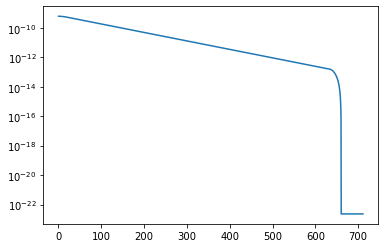

In [673]:
def get_kde_xy(N, num=3000):
    kde = FFTKDE(bw=6.0, kernel="epa")
    low_bound = 0
    data = N[:, 0]
    data = np.concatenate((data, 2 * low_bound - data))
    weight = np.concatenate((N[:, 1], N[:, 1]))
    kde.fit(data, weight)
    x, y = kde.evaluate(num)
    y = y*2* N[:, -1].sum()
    idx = x > 0
    x = x[idx]
    y = y[idx]
    return x, y
max_size = 700
valid_idx = N_pac[:, 0] <= max_size

pac_x, pac_y = get_kde_xy(N_pac[valid_idx])
plt.plot(pac_x, pac_y)
plt.yscale("log")

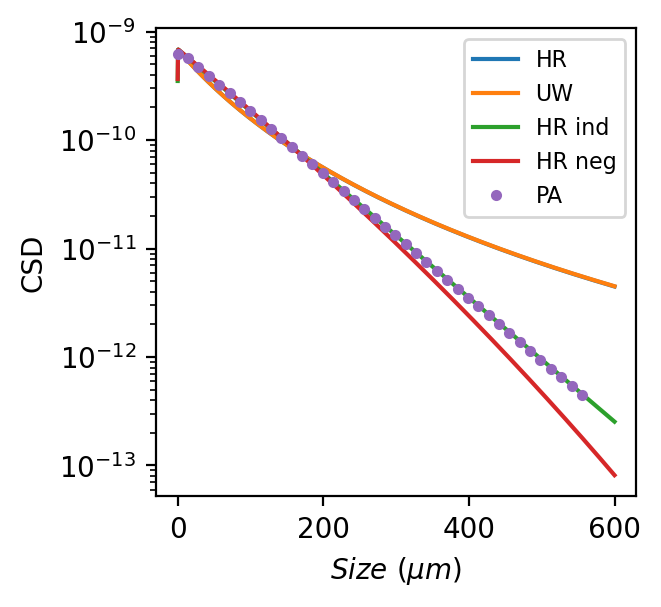

In [674]:
fig, ax = plt.subplots(figsize=(3.1, 3.1), dpi=200)

lim = slice(0, 1200)

ax.plot(L_centers[lim], n_hr[lim], label="HR")
ax.plot(L_centers[lim], n_uw[lim], label="UW")
ax.plot(L_centers[lim], n_hr_ind[lim], label="HR ind")
ax.plot(L_centers[lim], n_hr_neg[lim], label="HR neg")
ax.plot(pac_x[:-300], pac_y[:-300], ".", label="PA", markevery=30)
# ax.plot(centers, nd, ".", markevery=1)
ax.set_xlabel("$Size\ (\mu m)$")
ax.set_ylabel("CSD")
ax.legend(fontsize=8)
# ax.set_xscale("log")
ax.set_yscale("log")


In [ ]:
长出王格外导致偏差！所以一个能对上一个对不上。
做个图 scale pa步长，和hr方法比较误差。

## Two stage

In [120]:
growth_fcn = hr_grid_forward_step_size_dependent_1d
residence_time = 1000
t_total = 1000
T = [31.5, 31]
time_step_scale = 0.7
    
dt_max = 1

n = [
    n_init.copy(),
    np.zeros_like(n_init)
]

c = [
    c_init,
    c_init
]

v = [trapz(nn * L_centers**3, L_centers) for nn in n]

t = 0
pbar = tqdm(total=t_total, desc="HR Continuous")

cs = [c.copy()]
ts =[t]
vs = [v.copy()]
cnts = [[trapz(nn, L_centers) for nn in n]]

num_stage = len(n)
G = [0.] * num_stage
B = [0.] * num_stage
while t < t_total:
    for i in range(num_stage):
        G[i] = growth_rate(T[i], c[i], L_centers)
        B[i] = birth_rate(T[i], c[i], v[i])


    # compute time step
    dt = dL / np.max(G)
    dt = np.min([dt, t_total-t, dt_max]) * time_step_scale
    
    # Update nucleation
    for i in range(num_stage):
        n[i][0] += B[i] * dt / dL
    
    # Update growth
    for i in range(num_stage):
        n[i] = growth_fcn(n[i], dL, dt, G[i])
    
    # Update concentration
    for i in range(num_stage):
        v_new = trapz(n[i] * L_centers ** 3, L_centers)
        c[i] -= (v_new - v[i]) * density
        v[i] = v_new
    
    # Update continuous
    for i in range(num_stage):
        if i == 0:
            # first stage
            c_in = c_init
            n_in = 0
        else:
            c_in = c[i-1]
            n_in = n[i-1]
        c[i] += (c_in - c[i]) * dt / residence_time
        n[i] += (n_in - n[i]) * dt / residence_time
    
    t += dt
    pbar.update(dt)
    
    ts.append(t)
    cs.append(c.copy())
    vs.append(v.copy())
    cnts.append([trapz(nn, L_centers) for nn in n])

pbar.close()

HR Continuous:   0%|          | 0/1000 [00:00<?, ?it/s]